In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
from numpy.random import default_rng
from node import Node
from priorityQueue import PQ

In [2]:
# The main class, which contains the necessary methods and properties, it is an abstract class for the game's two modes.
class GridGame(ABC):
    
    # constructor method to iniialize the game with the height and width an the max number a cell can take, finally create an empty array
    def __init__(self, height=5, width=5, n=9):
        
        self.height = height
        self.width = width
        self.n = n
        self.grid = []
        
    
    # This method is responsible for build the game, essentially filling the grid with numbers
    def buildTheGame(self, distribution="normal"):
        
        #check the distribution and act according to it
        if distribution == "lognormal":
            self.grid = np.random.lognormal(0, 1, (self.height, self.width))
            
        elif distribution == 'uniform':
            self.grid = np.random.uniform(0, 9, (self.height, self.width))
            
        elif distribution == 'gamma':
            self.grid = np.random.gamma(5, 1, (self.height, self.width))
        
        elif distribution == "poisson":
            self.grid = np.random.poisson(5, (self.height, self.width))
            
        else:
             rng = default_rng()
             self.grid = rng.integers(0, self.n, (self.height, self.width))
                
        
        #assign the value in the cell[0][0] to 0 and return the grid
        self.grid[0][0] = 0
        return self.grid
    
    # This method is reponsible for visualize the gird using matplotlib library, it takes as parameter the grid
    def visualizeTheGrid(self, grid):
        height = len(grid)
        width = len(grid[0])
        title = "Grid Game"
        xlabel = "Width"
        ylabel = "Heigth"
        plt.figure(figsize=(height, width))
        
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.tick_params(labelsize=14)
        img = plt.imshow(grid)
        plt.colorbar(img)
        #changing the font according to the size of the grid, and also visalize the number it each cell
        fontSize=14
        if width > 10 and height > 10:
            fontSize = 25
        for y in range(height):
            for x in range(width):
                plt.text(x , y, '%.f' % self.grid[y, x],
                horizontalalignment='center',
                verticalalignment='center',
                fontsize=fontSize
              )
        plt.show()
    
    
    # this methoc checks for boundaris and return the adjacent cell to each cell, it takes as input the node it self
    def get_adjacent(self, node):
        
        # getting i and j from the node
        i = node[0]
        j = node[1]
        neighbors = []
        
        #start loking for neighbors of each cell, add them to the neighbors array, then return the array at the end
        if i == 0 and j == 0:
            neighbors.append([i, j+1, self.grid[i][j+1]])
            neighbors.append([i+1, j, self.grid[i+1][j]])
        
        elif i > 0 and i < self.height-1 and j == 0:   
            neighbors.append([i-1, j, self.grid[i-1][j]])
            neighbors.append([i+1, j, self.grid[i+1][j]])
            neighbors.append([i, j+1, self.grid[i][j+1]])
        
        elif i == self.height-1 and j == 0:
            neighbors.append([i-1, j, self.grid[i-1][j]])
            neighbors.append([i, j+1, self.grid[i][j+1]])
        
        elif i == 0 and j > 0 and j < self.width-1:
            neighbors.append([i+1, j, self.grid[i+1][j]])
            neighbors.append([i, j-1, self.grid[i][j-1]])
            neighbors.append([i, j+1, self.grid[i][j+1]])
        
        elif i == 0 and j == self.width-1:
            neighbors.append([i+1, j, self.grid[i+1][j]])
            neighbors.append([i, j-1, self.grid[i][j-1]])
        
        elif i > 0 and i < self.height-1 and j == self.width-1:
            neighbors.append([i-1, j, self.grid[i-1][j]])
            neighbors.append([i+1, j, self.grid[i+1][j]])
            neighbors.append([i, j-1, self.grid[i][j-1]])
        
        elif i == self.height-1 and j > 0 and j < self.width-1:
            neighbors.append([i-1, j, self.grid[i-1][j]])
            neighbors.append([i, j+1, self.grid[i][j+1]])
            neighbors.append([i, j-1, self.grid[i][j-1]])
        
        elif i == self.height-1 and j == self.width-1:
            neighbors.append([i-1, j, self.grid[i-1][j]])
            neighbors.append([i, j-1, self.grid[i][j-1]])
        
        else:
            neighbors.append([i-1, j, self.grid[i-1][j]])
            neighbors.append([i+1, j, self.grid[i+1][j]])
            neighbors.append([i, j-1, self.grid[i][j-1]])
            neighbors.append([i, j+1, self.grid[i][j+1]])
        
        return neighbors
    
    
    
    def mean(self, path):
        weight_path = []
        
        for p in range(len(path)):
            i = path[p][0]
            j = path[p][1]
            weight_path.append(self.grid[i][j])
        
        return round(np.mean(weight_path), 2)
    
    def variance(self, path):
        weight_path = []
        
        for p in range(len(path)):
            i = path[p][0]
            j = path[p][1]
            weight_path.append(self.grid[i][j])
        
        return round(np.var(weight_path), 2)
    
    
            
    
    # The abstract method needs to be implemented in the subclasses, it is represents the naive approach for the task. more details in the subclasses
    @abstractmethod
    def findPath(self, grid, i=0, j=0, path=[[0, 0]]):
        pass
    
    
    # Second abstract method to be implemented, it is reponsible for compute the pasth and return the cost.
    @abstractmethod
    def computePath(self, grid, path):
        pass
    
    
    # Last abstract method for this class, the Dijkstra algorithm 
    @abstractmethod
    def dijkstra(self, grid):
        pass


In [3]:
# The first subclass, this class will inherit the properties and methods from the GridGame class. 
#In this mode, the cost of each cell is the number inside the cell itself
class numberInCellMode(GridGame):
    
    """
    findPath method to find the path in the naive approach. Basically, it uses the recursion approach to find the shortest path. 
    It takes as input the grid, the postion i j of the current cell, and the path
    """
    def findPath(self, grid, i=0, j=0, path=[[0, 0]]):
        
        """
        Basically, this method starts from cell[0][0], and start comparing the value of adjacents right and buttom cells, and choose the smalles one
        after it finds the smalles value in adjacents cells, it appends the values of this cell to the path array
        and recall itself with the value of the new cell also the path to keep track the cells selected and return at the end
        """
        if i < len(grid)-1 and j < len(grid[0])-1:
            if grid[i+1][j] >= grid[i][j+1]:
                path.append([i, j+1])
                return self.findPath(grid, i, j+1, path)
            else:
                path.append([i+1, j])
                return self.findPath(grid, i+1, j, path)
        
        elif i == len(grid)-1 and j < len(grid[0])-1:
            path.append([i, j+1])
            return self.findPath(grid, i, j+1, path)
            
        elif j == len(grid[0])-1 and i < len(grid)-1:
            path.append([i+1, j])
            return self.findPath(grid, i+1, j, path)
        else:
            return path
    
    # This method takes as input the gird and also the path to return the total cost
    def computePath(self, grid, path):
        
        # copy the grid to newGrid and initialize the cost to 0
        newGrid = np.copy(grid)
        cost = 0
        
        # for each cell in the path, it will assign -10 to it in the newGrid, and it will add the value to the cost from the original one
        for cell in path:
            i = cell[0]
            j = cell[1]
            newGrid[i][j] = -10
            cost += grid[i][j]
            
        # finally, it will print the cost and visualeze the grid with the path
        # the value -10 in the cells path helps to visualize the path.
        print(f"The total cost is: {cost}")
        #self.visualizeTheGrid(newGrid)
        return cost, newGrid
    

    # Implementation of dijkstra's algorithm to find the shortest path
    def dijkstra(self, grid):
        
        # First initialize 2 variables for the height and width of the grid
        height = len(grid)
        width = len(grid[0])
        # initialize two empty arrays, one to keep track visited node, the other is to store the path and return it
        visited = []
        path = []
        # initialize a numpy array of object (Node)
        nodes = np.empty((height, width), dtype=object)
        
        # fill the nodes np-array with the actual node from the grid
        # Node class is imported from another python file
        for i in range(len(grid)):
                for j in range(len(grid[0])):
                    node = Node(i, j, grid[i][j])
                    nodes[i][j] = node
        
        nodes[0][0].distance = 0
        
        # initialize the priority Queue, also it is imported from another python file
        # put the first node to the priority Queue
        pq = PQ()
        node_0 = nodes[0][0]
        pq.put(node_0)
        
        # iterate over the pq until its empty
        while not pq.isEmpty():
            
            # get the top of pq
            current_node = pq.get()
            visited.append(current_node)
            current_i = current_node.i
            current_j = current_node.j
            
            # get all neighbors for the current cell using get_adjacent method 
            for neighbor in self.get_adjacent([current_i, current_j]):
                i = neighbor[0]
                j = neighbor[1]
                distance = neighbor[2]
                
                # if the cell not visited, check the old cost and the new one
                # compare them
                if neighbor not in visited:
                    newNode = nodes[i][j]
                    old_cost = newNode.distance
                    # the new cost here will be the sum of the of the distance to the current node in the PQ plus the weight of the adjacent cell
                    new_cost = current_node.distance + distance
                    
                    # if the new cost smaller then old cost, update the distance of the node
                    # put the node in the PQ, and assign the pre attribute to the node behind
                    if new_cost < old_cost:
                        pq.put(newNode)
                        nodes[i][j].distance = new_cost
                        nodes[i][j].pre = [current_i, current_j]
            
        
        # after we iterate over all the grid, now we need to append the path from destination to source in the path array
        i = len(grid)-1
        j = len(grid[0])-1
        
        # basically, here we appedn the last cell(destination cell), then start looking for the previous cell
        # in this way, we can track the path from destination to source
        complate = False
        while not complate:
            path.append([i, j])
            if nodes[i][j].pre is not None:
                k = i
                x = j
                i = nodes[k][x].pre[0]
                j = nodes[k][x].pre[1]
            else: complate = True
            
        # finally return the reversed path, because the path will be from destination to source
        # we want it to be from source to destination
        return list(reversed(path))



In [4]:
class AbsoluteValueMode(GridGame):

    # findPath method works same way as in mode one, but instead of comparing the values, it compares the absolute differences
    def findPath(self, grid, i=0, j=0, path=[[0, 0]]):
        if i < len(grid)-1 and j < len(grid[0])-1:
            if abs(grid[i][j] - grid[i+1][j]) >= abs(grid[i][j] - grid[i][j+1]):
                path.append([i, j+1])
                return self.findPath(grid, i, j+1, path)
            else:
                path.append([i+1, j])
                return self.findPath(grid, i+1, j, path)
        
        elif i == len(grid)-1 and j < len(grid[0])-1:
           path.append([i, j+1])
           return self.findPath(grid, i, j+1, path)
            
        elif j == len(grid[0])-1 and i < len(grid)-1:
            path.append([i+1, j])
            return self.findPath(grid, i+1, j, path)
        else:
            return path
    
    #computePath method works same way as in mode one, but instead to just adding the value from cell's path, it adds the absolute differences
    def computePath(self, grid, path):
        newGrid = np.copy(grid)
        prevCost = grid[0][0]
        newGrid[0][0] = -10
        currentCost = 0
        cost = 0
        for cell in range(1, len(path)):
            prevI = path[cell-1][0]
            prevJ = path[cell-1][1]
            currentI = path[cell][0]
            currentJ = path[cell][1]
            
            prevCost = grid[prevI][prevJ]
            currentCost = grid[currentI][currentJ]
            
            cost += abs(prevCost - currentCost)
            newGrid[currentI][currentJ] = -10
            
        print(f"The total cost is: {cost}")
        #self.visualizeTheGrid(newGrid)
        return cost, newGrid
             
    
    
    # same implementation like before, but here new cost will be the sum of the destination for the cell 
    # plus the absolute value between the current cell's weight and adjacent cell  
    def dijkstra(self, grid):
        height = len(grid)
        width = len(grid[0])
        visited = []
        path = []
        nodes = np.empty((height, width), dtype=object)
        
        for i in range(len(grid)):
                for j in range(len(grid[0])):
                    node = Node(i, j, grid[i][j])
                    nodes[i][j] = node
    
        nodes[0][0].distance = 0
        pq = PQ()
        node_0 = nodes[0][0]
        pq.put(node_0)
        
        while not pq.isEmpty():
            
            current_node = pq.get()
            visited.append(current_node)
            current_i = current_node.i
            current_j = current_node.j
            
            for neighbor in self.get_adjacent([current_i, current_j]):
                i = neighbor[0]
                j = neighbor[1]
                distance = neighbor[2]
                if neighbor not in visited:
                    newNode = nodes[i][j]
                    old_cost = newNode.distance
                    new_cost = current_node.distance + abs( current_node.weight - distance)
                    if new_cost < old_cost:
                        pq.put(newNode)
                        nodes[i][j].distance = new_cost
                        nodes[i][j].pre = [current_i, current_j]
                        
                        
        i = len(grid)-1
        j = len(grid[0])-1
        complate = False
        while not complate:
            path.append([i, j])
            if nodes[i][j].pre is not None:
                k = i
                x = j
                i = nodes[k][x].pre[0]
                j = nodes[k][x].pre[1]
            else: complate = True
            
        return list(reversed(path))

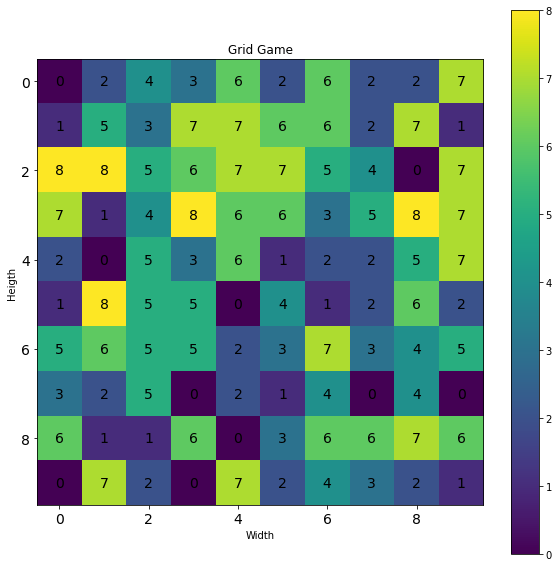

The total cost is: 47


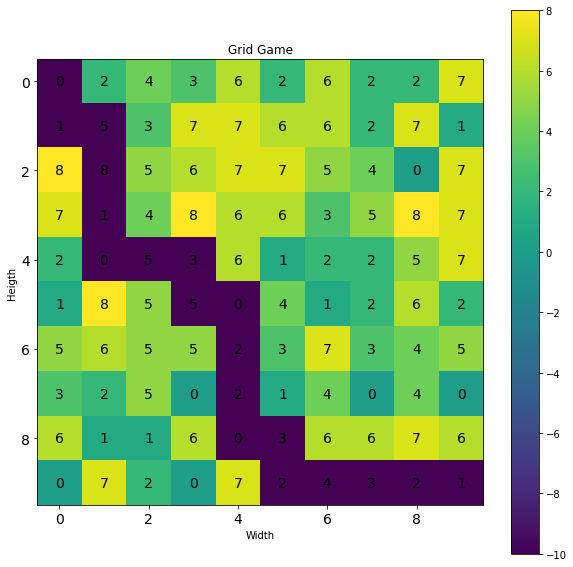

In [5]:
gridGame = numberInCellMode(10, 10)
grid = gridGame.buildTheGame()
gridGame.visualizeTheGrid(grid)
path = gridGame.dijkstra(grid)
cost, newGrid = gridGame.computePath(grid, path)
gridGame.visualizeTheGrid(newGrid)

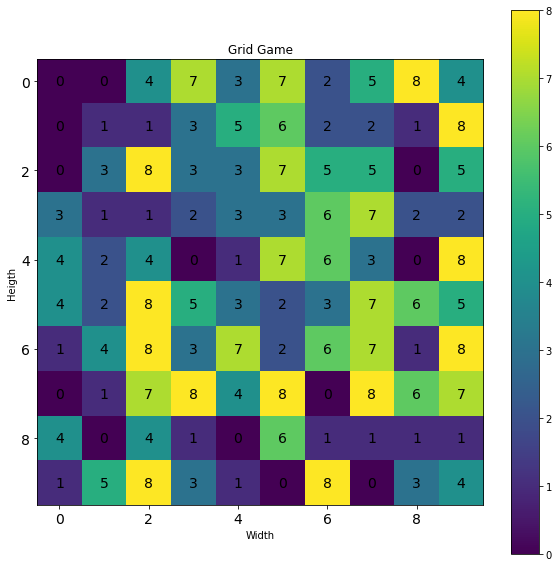

The total cost is: 22


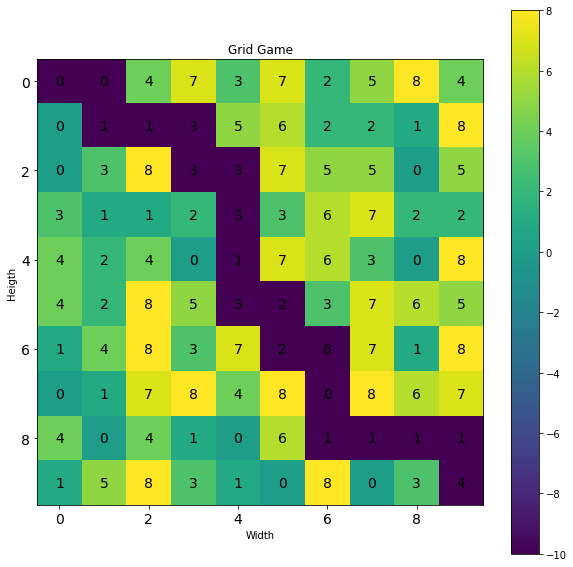

In [6]:
gridGame = AbsoluteValueMode(10, 10)
grid = gridGame.buildTheGame()
gridGame.visualizeTheGrid(grid)
path = gridGame.dijkstra(grid)
cost, newGrid = gridGame.computePath(grid, path)
gridGame.visualizeTheGrid(newGrid)

In [7]:
def analyze_the_size():
    sizes = [5, 10, 25, 50]
    costs = []
    #variances = []
    #means = []
    
    for size in sizes:
        gridGame = numberInCellMode(size, size)
        grid = gridGame.buildTheGame(distribution='uniform')
        path = gridGame.dijkstra(grid)
        cost, newGrid = gridGame.computePath(grid, path)
        #variance = gridGame.variance(path)
        #mean = gridGame.mean(path)
        costs.append(cost)
        #means.append(mean)
        #variances.append(variance)
    
    plt.figure()
    plt.plot(costs)

    

def check_execution_time():
    sizes = [5, 10, 20, 30, 40, 50, 100, 200]
    times = []
    
    for size in sizes:
        gridGame = numberInCellMode(size, size)
        grid = gridGame.buildTheGame()
        start_time = time.time()
        path = gridGame.dijkstra(grid)
        finish_time = time.time()
        seconds = finish_time - start_time
        print(seconds)
        times.append(seconds)
    
    plt.figure()
    plt.plot(times)

The total cost is: 23.261392770931213
The total cost is: 47.93189674062276
The total cost is: 108.48217139098288
The total cost is: 223.1615439090845


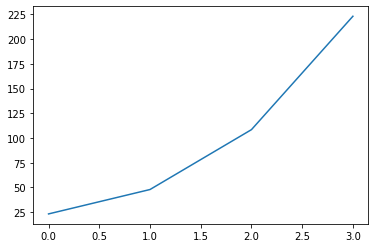

In [8]:
analyze_the_size()

0.0
0.001993894577026367
0.010970830917358398
0.03593707084655762
0.08876681327819824
0.21642756462097168
4.309625148773193
79.85855865478516


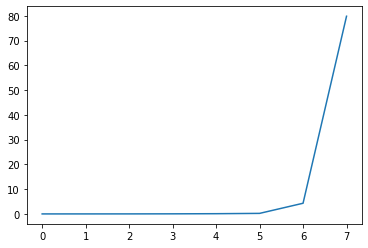

In [9]:
check_execution_time()